# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

import math

# Simulator

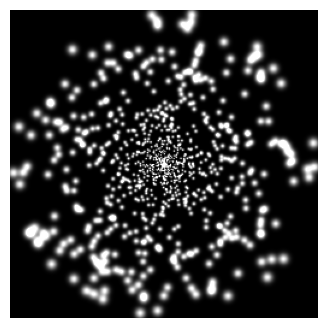

In [2]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu(), cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

Loss = 0.0343:   0%|                                    | 1/2000 [00:00<03:31,  9.45iter/s]

Loss = 0.0032: 100%|████████████████████████████████| 2000/2000 [00:08<00:00, 234.67iter/s]


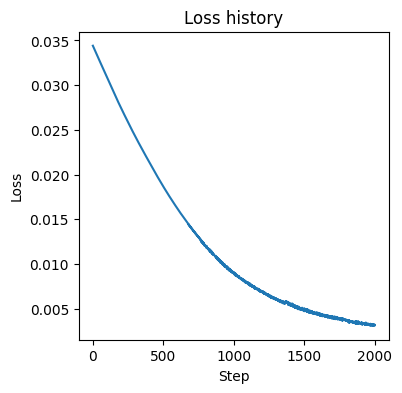

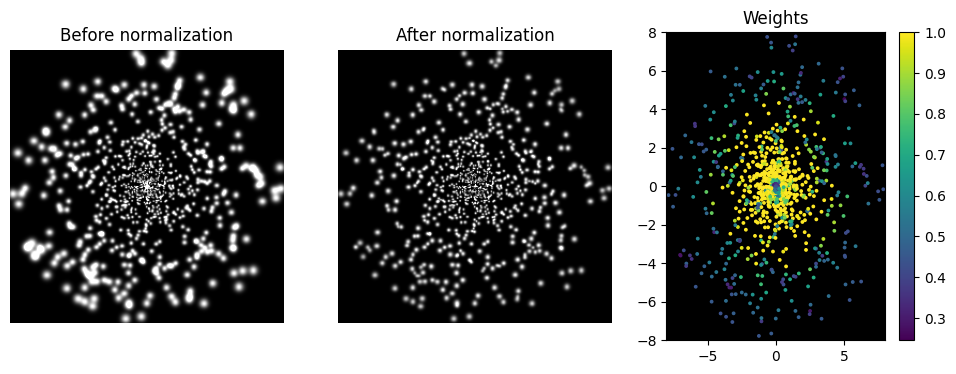

Percentage of amplitude: 75.77%


In [3]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu(), cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu(), cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [ ]:
from phosphene.density import VisualFieldMapper

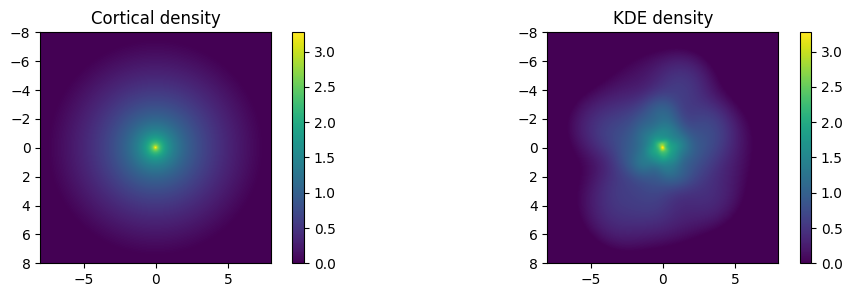

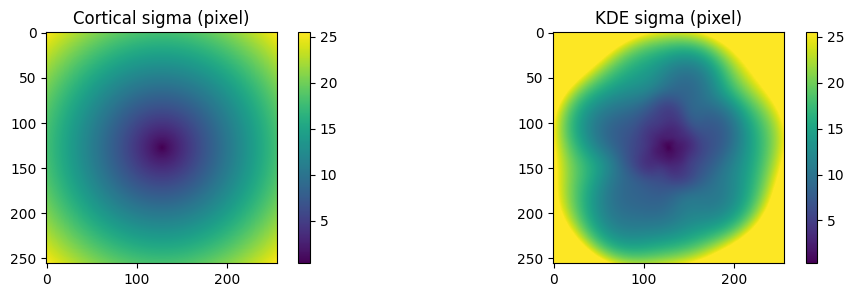

In [5]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

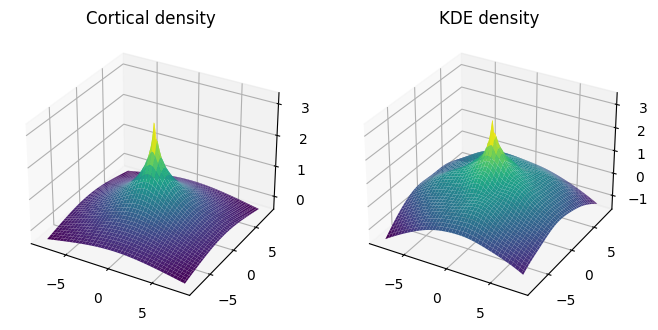

In [6]:
# 3d plot of the cortical density maps
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(np.linspace(-fov/2, fov/2, density_cortical.shape[1]), np.linspace(-fov/2, fov/2, density_cortical.shape[0]))
ax.plot_surface(X, Y, np.log10(density_cortical), cmap='viridis')
ax.set_title('Cortical density')

ax = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(np.linspace(-fov/2, fov/2, density_kde.shape[1]), np.linspace(-fov/2, fov/2, density_kde.shape[0]))
ax.plot_surface(X, Y, np.log10(density_kde), cmap='viridis')
ax.set_title('KDE density')
plt.show()

# Optimization with ML

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import torch.nn as nn

import tqdm

import piq

# clear output
from IPython.display import clear_output

In [8]:
def visualize_sample(images, phosphenes, epoch, step, losses):
    """Visualize the first image in the batch and its corresponding phosphene output."""
    plt.figure(figsize=(15, 5))
    # Natural image: convert from (C,H,W) to (H,W,C)
    plt.subplot(1, 3, 1)
    # normalize between 0 and 1
    image = images[0]
    image = (image - image.min()) / (image.max() - image.min())
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Input Image\n(Epoch {epoch}, Step {step})')
    
    # Phosphene image (grayscale)
    plt.subplot(1, 3, 2)
    plt.imshow(phosphenes[0][0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.title(f'Output Phosphene Image\n(Epoch {epoch}, Step {step})')

    # Loss history
    plt.subplot(1, 3, 3)
    plt.plot(losses)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss history')
    
    plt.tight_layout()
    plt.show()

In [9]:
def convlayer(n_input, n_output, k_size=3, stride=1, padding=1, resample_out=None):
    layer = [
        nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(n_output),
        nn.LeakyReLU(inplace=True),
        resample_out]
    if resample_out is None:
        layer.pop()
    return layer

class ResidualBlock(nn.Module):
    def __init__(self, n_channels, stride=1, resample_out=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.relu = nn.LeakyReLU(inplace=False)
        self.conv2 = nn.Conv2d(n_channels, n_channels,kernel_size=3, stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(n_channels)
        self.resample_out = resample_out

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        if self.resample_out:
            out = self.resample_out(out)
        return out

class E2E_Encoder(nn.Module):
    """
    Simple non-generic encoder class that receives 128x128 input and outputs 32x32 feature map as stimulation protocol
    """
    def __init__(self, in_channels=3, out_channels=1, n_electrodes=1024, out_scaling=1e-4, out_activation='relu', flattened_feature_size=1024):
        super(E2E_Encoder, self).__init__()
        self.output_scaling = out_scaling
        self.out_activation = {'tanh': nn.Tanh(), ## NOTE: simulator expects only positive stimulation values 
                               'sigmoid': nn.Sigmoid(),
                               'relu': nn.ReLU(),
                               'softmax':nn.Softmax(dim=1)}[out_activation]

        # Model
        self.model = nn.Sequential(*convlayer(in_channels,8,3,1,1),
                                   *convlayer(8,16,3,1,1,resample_out=nn.MaxPool2d(2)),
                                   *convlayer(16,32,3,1,1,resample_out=nn.MaxPool2d(2)),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   ResidualBlock(32, resample_out=None),
                                   *convlayer(32,16,3,1,1),
                                   nn.Conv2d(16,1,3,1,1),
                                   nn.Flatten(),
                                   nn.Linear(flattened_feature_size, n_electrodes),
                                   self.out_activation)

    def forward(self, x):
        self.out = self.model(x)
        stimulation = self.out*self.output_scaling #scaling improves numerical stability
        return stimulation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import functools
from typing import Union

import torch
import torch.nn.functional as F

from torch.nn.modules.loss import _Loss

from piq.utils import _validate_input, _parse_version, _reduce
from piq.functional import similarity_map, gradient_map, scharr_filter, gaussian_filter, rgb2yiq, imresize


# If you want SSIM from piq, import it:
# pip install piq
import piq

def _normalize_to_distribution(x: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """Normalize saliency map to a distribution that sums to 1 over spatial dims."""
    denom = x.sum(dim=(-2, -1), keepdim=True) + eps
    return x / denom

def kl_div_loss(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    KL divergence between two 2D distributions.
    pred, target: (N, 1, H, W)
    """
    pred = _normalize_to_distribution(pred, eps)
    target = _normalize_to_distribution(target, eps)
    kl = target * (torch.log(target + eps) - torch.log(pred + eps))
    # Sum over spatial dims, then mean over batch
    return kl.sum(dim=(-2, -1)).mean()

def js_div_loss(pred: torch.Tensor, target: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """
    Jensen–Shannon divergence between two 2D distributions.
    JS(P||Q) = 0.5 * KL(P||M) + 0.5 * KL(Q||M), where M = 0.5*(P+Q)
    """
    pred = _normalize_to_distribution(pred, eps)
    target = _normalize_to_distribution(target, eps)
    m = 0.5 * (pred + target)
    kl_pm = pred * (torch.log(pred + eps) - torch.log(m + eps))
    kl_tm = target * (torch.log(target + eps) - torch.log(m + eps))
    js = 0.5 * kl_pm.sum(dim=(-2, -1)) + 0.5 * kl_tm.sum(dim=(-2, -1))
    return js.mean()

def _spectral_residual_visual_saliency(x: torch.Tensor, scale: float = 0.25, kernel_size: int = 3,
                                       sigma: float = 3.8, gaussian_size: int = 10) -> torch.Tensor:
    r"""Compute Spectral Residual Visual Saliency
    Credits X. Hou and L. Zhang, CVPR 07, 2007
    Reference:
        http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.125.5641&rep=rep1&type=pdf

    Args:
        x: Tensor with shape (N, 1, H, W).
        scale: Resizing factor
        kernel_size: Kernel size of average blur filter
        sigma: Sigma of gaussian filter applied on saliency map
        gaussian_size: Size of gaussian filter applied on saliency map
    Returns:
        saliency_map: Tensor with shape BxHxW

    """
    eps = torch.finfo(x.dtype).eps
    for kernel in kernel_size, gaussian_size:
        if x.size(-1) * scale < kernel or x.size(-2) * scale < kernel:
            raise ValueError(f'Kernel size can\'t be greater than actual input size. '
                             f'Input size: {x.size()} x {scale}. Kernel size: {kernel}')

    # Downsize image
    in_img = imresize(x, scale=scale)

    # Fourier transform (use complex format [a,b] instead of a + ib
    # because torch<1.8.0 autograd does not support the latter)
    recommended_torch_version = _parse_version('1.8.0')
    torch_version = _parse_version(torch.__version__)
    if len(torch_version) != 0 and torch_version >= recommended_torch_version:
        imagefft = torch.fft.fft2(in_img)
        log_amplitude = torch.log(imagefft.abs() + eps)
        phase = torch.angle(imagefft)
    else:
        imagefft = torch.rfft(in_img, 2, onesided=False)
        # Compute log of absolute value and angle of fourier transform
        log_amplitude = torch.log(imagefft.pow(2).sum(dim=-1).sqrt() + eps)
        phase = torch.atan2(imagefft[..., 1], imagefft[..., 0] + eps)

    # Compute spectral residual using average filtering
    padding = kernel_size // 2
    if padding:
        up_pad = (kernel_size - 1) // 2
        down_pad = padding
        pad_to_use = [up_pad, down_pad, up_pad, down_pad]
        # replicate padding before average filtering
        spectral_residual = F.pad(log_amplitude, pad=pad_to_use, mode='replicate')
    else:
        spectral_residual = log_amplitude

    spectral_residual = log_amplitude - F.avg_pool2d(spectral_residual, kernel_size=kernel_size, stride=1)
    # Saliency map
    # representation of complex exp(spectral_residual + j * phase)
    compx = torch.stack((
        torch.exp(spectral_residual) * torch.cos(phase),
        torch.exp(spectral_residual) * torch.sin(phase)), -1)

    if len(torch_version) != 0 and torch_version >= recommended_torch_version:
        saliency_map = torch.abs(torch.fft.ifft2(torch.view_as_complex(compx))) ** 2

    else:
        saliency_map = torch.sum(torch.ifft(compx, 2) ** 2, dim=-1)

    # After effect for SR-SIM
    # Apply gaussian blur
    kernel = gaussian_filter(gaussian_size, sigma, device=saliency_map.device, dtype=saliency_map.dtype)
    if gaussian_size % 2 == 0:  # matlab pads upper and lower borders with 0s for even kernels
        kernel = torch.cat((torch.zeros(1, 1, gaussian_size,
                            device=saliency_map.device, dtype=saliency_map.dtype), kernel), 1)
        kernel = torch.cat((torch.zeros(1, gaussian_size + 1, 1,
                            device=saliency_map.device, dtype=saliency_map.dtype), kernel), 2)
        gaussian_size += 1
    kernel = kernel.view(1, 1, gaussian_size, gaussian_size)
    saliency_map = F.conv2d(saliency_map, kernel, padding=(gaussian_size - 1) // 2)

    # normalize between [0, 1]
    min_sal = torch.min(saliency_map[:])
    max_sal = torch.max(saliency_map[:])
    saliency_map = (saliency_map - min_sal) / (max_sal - min_sal + eps)

    # scale to original size
    saliency_map = imresize(saliency_map, sizes=x.size()[-2:])
    return saliency_map.clip(0, 1)


class SaliencyLoss(nn.Module):
    """
    Computes the saliency map for both pred and target, then
    applies a chosen distance metric: ['mse', 'l1', 'kl', 'js', 'ssim'].
    """
    def __init__(
        self,
        loss_type: str = 'mse',
        scale: float = 0.25,
        kernel_size: int = 3,
        sigma: float = 3.8,
        gaussian_size: int = 10
    ):
        """
        Args:
            loss_type: Which distance to use: 'mse', 'l1', 'kl', 'js', or 'ssim'.
            scale: Resizing factor for the SR saliency function.
            kernel_size: Kernel size for average blur in SR saliency.
            sigma: Sigma for the Gaussian blur in SR saliency.
            gaussian_size: Size of the Gaussian kernel in SR saliency.
        """
        super().__init__()
        self.loss_type = loss_type.lower()
        self.scale = scale
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.gaussian_size = gaussian_size
        self.pred_sal = None
        self.gt_sal = None

        if self.loss_type == 'ssim':
            # For SSIM from piq, you must specify the data_range
            # which should match the max pixel value of the saliency map.
            # Since saliency is normalized to [0,1], data_range=1.0.
            self.ssim_loss = piq.SSIMLoss(data_range=1.0)

    def forward(self, pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Args:
            pred: (N, 1, H, W) or (N, 3, H, W) predicted image/batch
            target: (N, 1, H, W) or (N, 3, H, W) target image/batch
        Returns:
            Scalar loss value
        """
        # 1. Compute saliency maps
        pred_sal = _spectral_residual_visual_saliency(
            pred, scale=self.scale, kernel_size=self.kernel_size,
            sigma=self.sigma, gaussian_size=self.gaussian_size
        )
        gt_sal = _spectral_residual_visual_saliency(
            target, scale=self.scale, kernel_size=self.kernel_size,
            sigma=self.sigma, gaussian_size=self.gaussian_size
        )
        self.pred_sal = pred_sal
        self.gt_sal = gt_sal

        # 2. Compare saliency maps
        if self.loss_type == 'mse':
            return F.mse_loss(pred_sal, gt_sal)
        elif self.loss_type == 'l1':
            return F.l1_loss(pred_sal, gt_sal)
        elif self.loss_type == 'kl':
            return kl_div_loss(pred_sal, gt_sal)
        elif self.loss_type == 'js':
            return js_div_loss(pred_sal, gt_sal)
        elif self.loss_type == 'ssim':
            # piq.SSIMLoss returns 1 - SSIM, so it’s already a “loss”
            return self.ssim_loss(pred_sal, gt_sal)
        else:
            raise ValueError(f"Unknown loss_type '{self.loss_type}'. "
                             f"Must be one of ['mse','l1','kl','js','ssim'].")


In [11]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 4

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
    ])

dataset = datasets.Imagenette(root='../../data', transform=transform, download=False)
# dataset = datasets.MNIST(root='../../data', transform=transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
params['run']['batch_size'] = batch_size
simulator = PhospheneSimulator(params, phosphene_coords)

# Loss
# loss_fn = compute_sliced_wasserstein_distance
# loss_fn = piq.ContentLoss(feature_extractor='vgg19', normalize_features=False, layers=['relu2_1'], distance="swd", reduction="mean").to(device)
# loss_fn = piq.ContentLoss(feature_extractor='vgg19', normalize_features=True, layers=['relu4_3', 'relu5_2'], weights=[1,1], distance="swd")
# loss_fn = piq.HaarPSILoss().cuda()
# loss_fn = piq.SSIMLoss().cuda()
# mutual information
# loss_fn = piq.MI()
# loss_fn = piq.SRSIMLoss().cuda()
# loss_fn = SaliencyLoss(loss_type='js', scale=0.25, kernel_size=7, sigma=2.0, gaussian_size=10)
# loss_fn = piq.SRSIMLoss().cuda()
loss_fn = piq.InformationWeightedSSIMLoss().cuda()

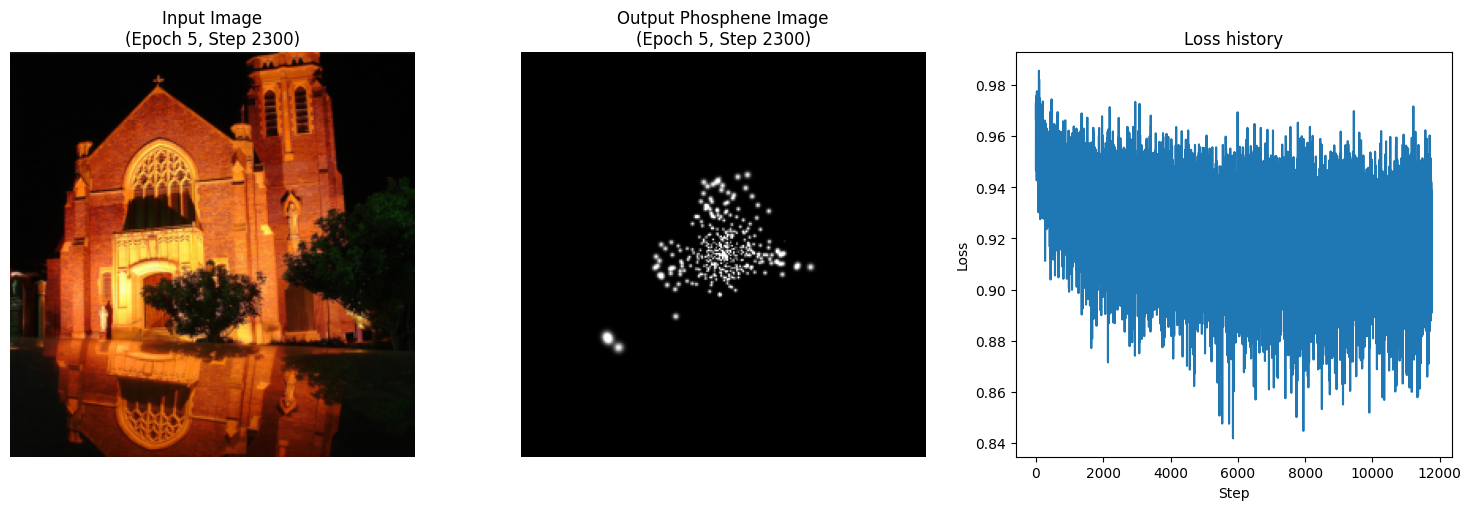

Epoch 5/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2368/2368 [03:34<00:00, 11.03it/s, loss=0.9172]

Epoch [5/5] Average Loss: 0.9171


In [91]:
torch.use_deterministic_algorithms(False)

in_channels = 1 if dataset[0][0].shape[0] == 1 else 3

# Instantiate your model, optimizer, and set number of epochs.
model = E2E_Encoder(in_channels=in_channels, out_channels=1, n_electrodes=1024, out_scaling=amplitude, 
                     out_activation='sigmoid', flattened_feature_size=1024*4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 5

losses = []

# Training loop using tqdm for elegant loss printing
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    pbar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), 
                     desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (images, _) in pbar:
        images = images.to(device).detach()

        if images.shape[0] != batch_size:
            continue
        stim = model(images)
        
        simulator.reset()
        phosphenes = simulator(stim).unsqueeze(1)
        
        loss = loss_fn(phosphenes, images.mean(1, keepdim=True))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses += [loss.item()]
        # Update tqdm postfix with the current loss value
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
        # Visualize every 100 steps
        if i % 100 == 0:
            clear_output(wait=True)
            visualize_sample(images, phosphenes, epoch+1, i, losses)
            # visualize_sample(loss_fn.gt_sal, loss_fn.pred_sal, epoch+1, i, losses)

    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")

# Log-likelihood

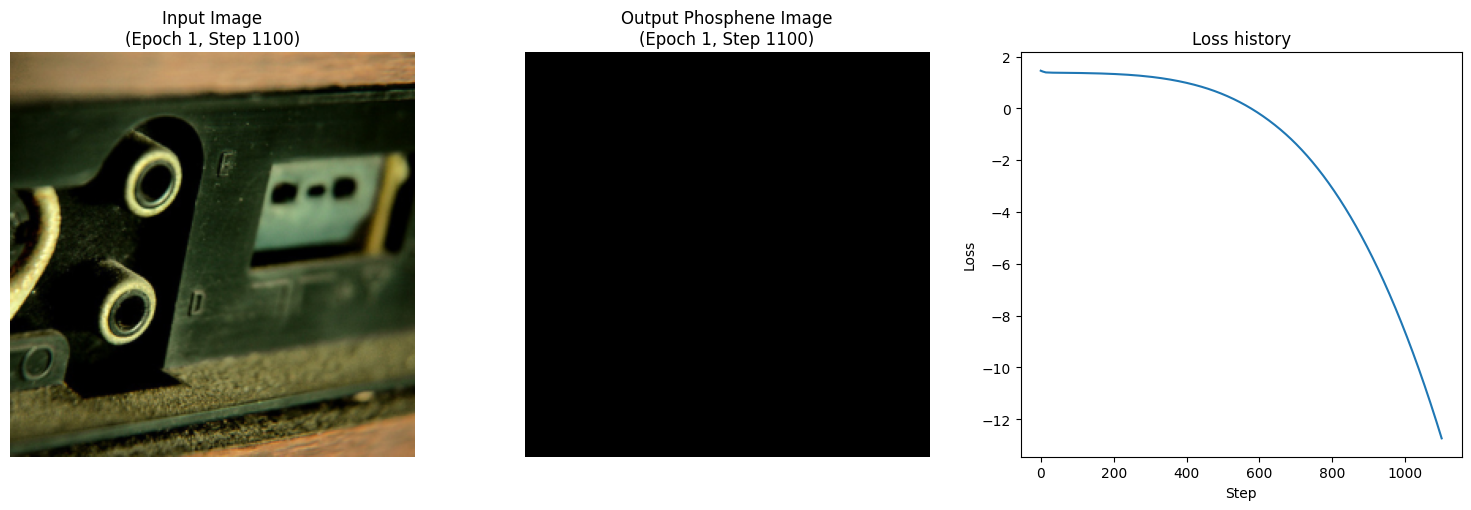

Epoch 1/5:  50%|████████████            | 1186/2368 [00:52<00:46, 25.40it/s, loss=-17.1376]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
from IPython.display import clear_output
import piq  # Assuming piq is installed

# -------------------------
# 1. Structured Prior Network
# -------------------------
class StructuredPriorNet(nn.Module):
    """
    A small CNN that takes a phosphene image (B, 1, H, W) and outputs a scalar
    log-likelihood for each image. Higher values indicate that the image is more likely
    to be "structured" (i.e. non-random).
    """
    def __init__(self):
        super(StructuredPriorNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)  # Output shape: (B, 32, 1, 1)
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        out = self.features(x)            # (B, 32, 1, 1)
        out = out.view(out.size(0), -1)     # (B, 32)
        log_prob = self.fc(out)             # (B, 1)
        return log_prob

# -------------------------
# 2. Simple Feature Extractor for Contrastive Loss
# -------------------------
class SimpleFeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_dim=128):
        super(SimpleFeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(32, out_dim)
        
    def forward(self, x):
        x = self.conv(x)                  # (B, 32, 1, 1)
        x = x.view(x.size(0), -1)           # (B, 32)
        x = self.fc(x)                    # (B, out_dim)
        return x

# -------------------------
# 3. Contrastive Loss (InfoNCE)
# -------------------------
def contrastive_loss(input_features, output_features, temperature=0.07):
    """
    input_features: (B, D) features from input images.
    output_features: (B, D) features from phosphene outputs.
    Computes an InfoNCE loss where corresponding pairs (diagonals) should be similar.
    """
    input_norm = F.normalize(input_features, dim=1)
    output_norm = F.normalize(output_features, dim=1)
    sim_matrix = torch.matmul(input_norm, output_norm.t()) / temperature  # (B, B)
    batch_size = input_features.size(0)
    labels = torch.arange(batch_size, device=input_features.device)
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

# -------------------------
# 4. Likelihood Ratio Loss using Structured Prior
# -------------------------
def likelihood_ratio_loss(phosphenes, structured_prior_net):
    """
    Returns -mean(log P_structured(phosphenes)). We assume the null model's log-prob is 0.
    """
    log_p_structured = structured_prior_net(phosphenes)  # (B, 1)
    return - torch.mean(log_p_structured)

# -------------------------
# 5. Instantiate Models & Optimizers
# -------------------------
# (Assume your E2E_Encoder and simulator are already defined as in your notebook.)
model = E2E_Encoder(in_channels=in_channels, out_channels=1, n_electrodes=1024, 
                     out_scaling=amplitude, out_activation='relu', flattened_feature_size=1024*4).to(device)
structured_prior_net = StructuredPriorNet().to(device)
feature_extractor_in = SimpleFeatureExtractor(in_channels=in_channels, out_dim=128).to(device)
feature_extractor_out = SimpleFeatureExtractor(in_channels=1, out_dim=128).to(device)

# We update all networks jointly.
optimizer = optim.Adam(list(model.parameters()) + list(structured_prior_net.parameters()) +
                       list(feature_extractor_in.parameters()) + list(feature_extractor_out.parameters()), lr=0.0001)

# Hyperparameters for loss weighting:
gamma = 0.1       # weight for likelihood ratio loss
lambda_l1 = 1   # weight for L1 sparsity penalty
temperature = 0.07

# (Optionally, you could also use a PIQ-based loss if you wish to compare perceptual content—but here we drop reconstruction.)

# -------------------------
# 6. Training Loop
# -------------------------
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    model.train()
    structured_prior_net.train()
    feature_extractor_in.train()
    feature_extractor_out.train()
    
    running_loss = 0.0
    pbar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader), 
                     desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for i, (images, _) in pbar:
        images = images.to(device)  # Input images
        
        if images.shape[0] != batch_size:
            continue
        
        # Forward pass: Encoder -> Simulator -> Phosphene Output
        stim = model(images)
        simulator.reset()
        # Simulator produces a phosphene percept; add a channel dim to get (B, 1, H, W)
        phosphenes = simulator(stim).unsqueeze(1)
        
        # --- Content Consistency via Contrastive Loss ---
        feat_in = feature_extractor_in(images)       # Features from input (B, 128)
        feat_out = feature_extractor_out(phosphenes)     # Features from phosphene output (B, 128)
        cont_loss = contrastive_loss(feat_in, feat_out, temperature=temperature)
        
        # --- Non-Random Structure via Likelihood Ratio Loss ---
        llr_loss = likelihood_ratio_loss(phosphenes, structured_prior_net)
        
        # --- Sparsity Loss ---
        sparsity_loss = torch.mean(torch.abs(phosphenes))
        
        # Total loss: combine contrastive, likelihood ratio, and sparsity terms.
        total_loss = cont_loss + gamma * llr_loss + lambda_l1 * sparsity_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        losses.append(total_loss.item())
        pbar.set_postfix({'loss': f"{total_loss.item():.4f}"})
        
        # Optional: visualize every 100 steps.
        if i % 100 == 0:
            clear_output(wait=True)
            visualize_sample(images, phosphenes, epoch+1, i, losses)
    
    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}")